In [16]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Data

In [2]:
data = load_breast_cancer()
X, y = data.data, data.target
data.feature_names


array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

### Check for Class Imbalance

Text(0, 0.5, 'Count')

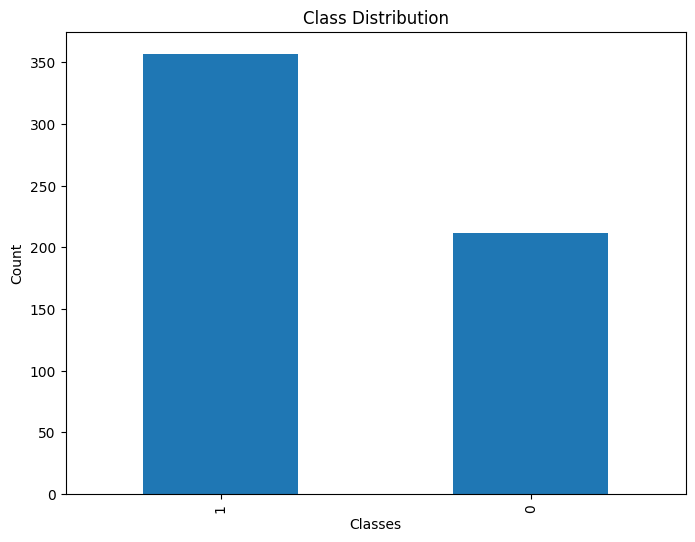

In [3]:
plt.figure(figsize=(8, 6))
pd.Series(y).value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')

In [4]:
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y)
class_weights = compute_class_weight('balanced', classes=classes, y=y)
class_weight_dict = dict(zip(classes, class_weights))
print(class_weight_dict)

{np.int64(0): np.float64(1.3419811320754718), np.int64(1): np.float64(0.7969187675070029)}


# Feature Importance

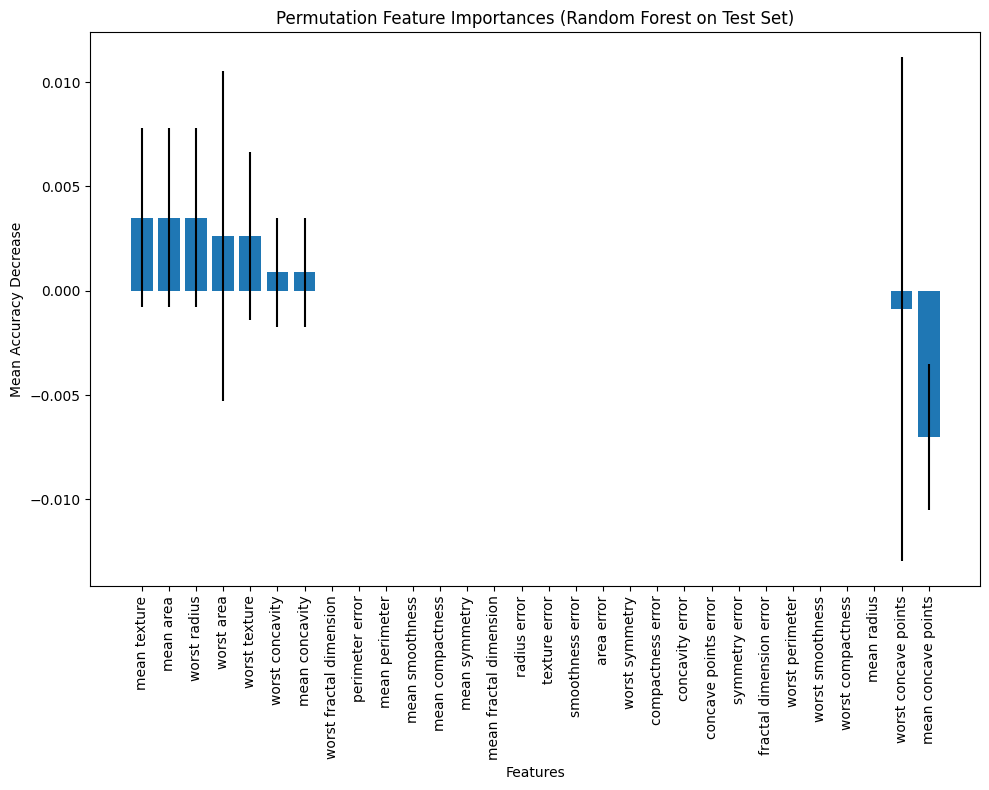

In [5]:
from sklearn.inspection import permutation_importance

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Train a classifier
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)

# Calculate permutation importance on the test set
result = permutation_importance(random_forest_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Get feature importances
sorted_indices = result.importances_mean.argsort()[::-1]
sorted_importances = result.importances_mean[sorted_indices]
sorted_std = result.importances_std[sorted_indices]
sorted_feature_names = data.feature_names[sorted_indices]


plt.figure(figsize=(10, 8))
plt.title("Permutation Feature Importances (Random Forest on Test Set)")
plt.bar(range(X_test.shape[1]), sorted_importances, yerr=sorted_std)
plt.xticks(range(X_test.shape[1]), sorted_feature_names, rotation=90)
plt.xlabel("Features")
plt.ylabel("Mean Accuracy Decrease")
plt.tight_layout()
plt.show()

In [7]:
accuracies = []
features_used = []
top_feature_indices = [] 

top_features = sorted_feature_names[:7]
mask = np.isin(data.feature_names, top_features)
feature_idx = np.where(mask)[0]

for i in range(1, len(top_features) + 1):
    idx_subset = feature_idx[:i]
    
    scaler = StandardScaler()
    X_train_subset = scaler.fit_transform(X_train[:, idx_subset])
    X_test_subset = scaler.transform(X_test[:, idx_subset])

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_subset, y_train)
    y_pred = model.predict(X_test_subset)
    acc = accuracy_score(y_test, y_pred)

    features_used.append(top_features[:i])
    top_feature_indices.append(idx_subset)  # Store the exact indices
    accuracies.append(acc)

# Create and display result table
result_df = pd.DataFrame({
    'Num_Features': list(range(1, len(feature_idx)+1)),
    'Features': features_used,
    'Accuracy': accuracies
})


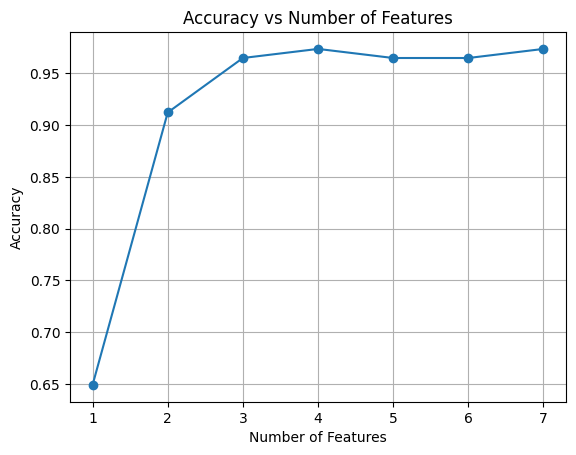

In [8]:
plt.plot(result_df['Num_Features'], result_df['Accuracy'], marker='o')
plt.title('Accuracy vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.xticks(result_df['Num_Features'])
plt.grid()
plt.show()

In [9]:
result_df

,Num_Features,Features,Accuracy
0,1,[mean texture],0.649123
1,2,"[mean texture, mean area]",0.912281
2,3,"[mean texture, mean area, worst radius]",0.964912
3,4,"[mean texture, mean area, worst radius, worst ...",0.973684
4,5,"[mean texture, mean area, worst radius, worst ...",0.964912
5,6,"[mean texture, mean area, worst radius, worst ...",0.964912
6,7,"[mean texture, mean area, worst radius, worst ...",0.973684


In [10]:
result_df.iloc[3].Features

array(['mean texture', 'mean area', 'worst radius', 'worst area'],
      dtype='<U23')

In [11]:
top_feature_indices[3]

array([ 1,  3,  6, 20])

# Random Forest

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[:, top_feature_indices[3]])
X_test_scaled = scaler.transform(X_test[:, top_feature_indices[3]])

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)  
y_pred = model.predict(X_test_scaled)  
print("Accuracy with selected features:", accuracy_score(y_test, y_pred))

Accuracy with selected features: 0.9736842105263158


In [13]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[42  1]
 [ 2 69]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97        43
           1       0.99      0.97      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



In [18]:
pipeline = make_pipeline(StandardScaler(), model)

scores = cross_val_score(pipeline, X[:, top_feature_indices[3]], y, cv=5)
print(f"Random Forest CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

Random Forest CV Accuracy: 0.9491 ± 0.0210


# Ensemble

In [19]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

## Models

In [20]:
class_weight_dict

{np.int64(0): np.float64(1.3419811320754718),
 np.int64(1): np.float64(0.7969187675070029)}

In [21]:
clf1 = LogisticRegression(max_iter=5000, random_state=42, class_weight="balanced")
clf2 = DecisionTreeClassifier(random_state=42, class_weight="balanced")
clf3 = SVC(probability=True, random_state=42, class_weight="balanced")
clf4 = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
clf5 = xgb.XGBClassifier(n_estimators=100, random_state=42, scale_pos_weight=1.34/0.80)

## Voting Classifier

In [22]:
voting_clf = VotingClassifier(estimators=[
    ('lr', clf1), 
    ('dt', clf2), 
    ('svc', clf3), 
    ('rf', clf4), 
    ('xgb', clf5)
], voting='soft')

from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 50],
    'lr__C': [0.1, 1, 10],  # Add regularization tuning
    'dt__max_depth': [None, 10, 20],  # Add decision tree tuning
    'svc__C': [0.1, 1, 10],  # Add SVC tuning
    'xgb__learning_rate': [0.1, 0.01],  # Add XGBoost tuning
}

random_search_voting = RandomizedSearchCV(
    estimator=voting_clf, 
    param_distributions=param_grid, 
    n_iter=20,  
    cv=3,       
    n_jobs=-1,  
    random_state=42
)
random_search_voting.fit(X_train[:, top_feature_indices[3]], y_train)
best_model_vote = random_search_voting.best_estimator_
y_pred_voting = best_model_vote.predict(X_test[:, top_feature_indices[3]])
print("Best Voting Classifier Accuracy:", accuracy_score(y_test, y_pred_voting))

Best Voting Classifier Accuracy: 0.9736842105263158


In [23]:
print(classification_report(y_test, y_pred_voting))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



In [28]:
#CV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(StandardScaler(), best_model_vote)

scores = cross_val_score(pipeline, X, y, cv=5)
print(f"Voting CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

Voting CV Accuracy: 0.9772 ± 0.0142


## Stacking Classifier

In [35]:
from sklearn.ensemble import StackingClassifier

stacked_clf = StackingClassifier(
    estimators=[
        ('lr', clf1),
        ('dt', clf2),
        ('svc', clf3),
        ('rf', clf4),
        ('xgb', clf5)
    ],
    final_estimator=LogisticRegression()
)

random_search_stack = RandomizedSearchCV(
    estimator=stacked_clf, 
    param_distributions=param_grid, 
    n_iter=20,  
    cv=3,       
    n_jobs=-1,  
    random_state=42
)       

random_search_stack.fit(X_train[:, top_feature_indices[3]], y_train)
best_model_stack = random_search_stack.best_estimator_
y_pred_stack = best_model_stack.predict(X_test[:, top_feature_indices[3]])
print("Best Stacking Classifier Accuracy:", accuracy_score(y_test, y_pred_stack))


Best Stacking Classifier Accuracy: 0.9824561403508771


In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_stack))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        43
           1       0.99      0.99      0.99        71

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [33]:

pipeline = make_pipeline(StandardScaler(), best_model_stack)

scores = cross_val_score(pipeline, X, y, cv=5)
print(f"Stacked CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

Stacked CV Accuracy: 0.9825 ± 0.0166


## Bayesian Model Averaging

In [30]:
from sklearn.metrics import log_loss

In [31]:
models = {
    'Voting Classifier': best_model_vote,
    'Stacking Classifier': best_model_stack
}

In [32]:

feature_indices = top_feature_indices[3] 

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

log_losses = []
accuracies = []
all_weights = []

for train_index, test_index in kf.split(X[:, feature_indices], y):

    X_train_cv = X[train_index][:, feature_indices]
    X_test_cv = X[test_index][:, feature_indices]
    y_train_cv, y_test_cv = y[train_index], y[test_index]

    # Preprocessing
    scaler = StandardScaler()
    X_train_cv = scaler.fit_transform(X_train_cv)
    X_test_cv = scaler.transform(X_test_cv)

    preds = {}
    losses = {}
    
    for name, model in models.items():
        model.fit(X_train_cv, y_train_cv)
        
        proba = model.predict_proba(X_test_cv)
        
        if proba.shape[1] == 1:
            proba = np.column_stack([1 - proba.ravel(), proba.ravel()])

        preds[name] = proba
        losses[name] = log_loss(y_test_cv, proba)

    epsilon = 1e-8
    inverse_losses = {k: 1 / (v + epsilon) for k, v in losses.items()}
    total = sum(inverse_losses.values())
    weights = {k: v / total for k, v in inverse_losses.items()}
    all_weights.append(weights.copy())

    # BMA prediction
    bma_pred = sum(weights[name] * preds[name] for name in models)
    bma_labels = np.argmax(bma_pred, axis=1)

    # Save scores
    log_losses.append(log_loss(y_test_cv, bma_pred))
    accuracies.append(accuracy_score(y_test_cv, bma_labels))

avg_weights = {name: np.mean([w[name] for w in all_weights]) for name in models}

print(f"BMA CV Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"BMA CV Log Loss: {np.mean(log_losses):.4f} ± {np.std(log_losses):.4f}")
print("\nAverage model weights across folds:")
print("Average weights:", avg_weights)


BMA CV Accuracy: 0.9596 ± 0.0119
BMA CV Log Loss: 0.1296 ± 0.0223

Average model weights across folds:
Average weights: {'Voting Classifier': np.float64(0.4901384200384243), 'Stacking Classifier': np.float64(0.5098615799615758)}
